# Image2Emoji Demo

- This notebook contains the demo for Image2Emoji, a Zero-shot Emoji Prediction model.  
- The model is based on OpenAI's CLIP model and is fine-tuned on Flickr-8k Dataset.  
- The model is able to predict the most relevant emoji for a given image.

## 📦 Installation
To install the required packages, run the following command:
```bash
pip install -r requirements.txt
```

In [1]:
#!pip install -r requirements.txt

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pytorch_lightning as pl
import torchvision
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np

from src import lightning_model
from src.data import get_dataloaders

# Fix seed
pl.seed_everything(0, workers=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

Seed set to 0


## 📚 Dataset
Dataset used for training the model is Flickr-8k dataset. The dataset contains 8,000 images that are each paired with captions.  
Training pipeline expects the dataset to be in the following structure:
```bash
root
└── Flickr8k
        ├── images
        └── captions.txt
        
```

In [254]:
if not os.path.exists('./Flickr8k'):
    !wget 'https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip'
    !unzip -q flickr8k.zip -d ./Flickr8k
    !rm flickr8k.zip
    !echo 'Downloaded Flickr8k dataset successfully.'

# Load data
train_loader, val_loader = get_dataloaders(data_dir='Flickr8k', tokenizer_name='albert-base-v2', batch_size=16, num_workers=2)

## 📎 Model
OpenAI's CLIP (Contrastive Language-Image Pretraining) model can embed different types of data into a common feature space by learning to predict which images correspond to which text descriptions.
I opted for lightweight models for each encoder (Pretrained ResNet18 for the image encoder and Pretrained ALBERT for the text encoder), aiming to deploy as a web application.
After training the model on the Flickr-8k dataset, the model is able to predict the most similar emoji for a given image by calculating the cosine similarity between the image and emoji embeddings.

![clip](pictures/clip.png)

In [4]:
# Load model
model = lightning_model.CLIPModel(image_encoder_alias='resnet18', text_encoder_alias='albert-base-v2')

## 🏃 Constrastive Pre-training
The model is trained using a contrastive loss function. It is trained to maximize the similarity between an image and its corresponding caption while minimizing the similarity between an image and a random caption. The model is trained for 10 epochs with a batch size of 16.

If you don't want to train the model, you can skip this section and directly jump to loading the trained model weights.

In [5]:
# # Train model
# trainer = pl.Trainer(max_epochs=10, enable_checkpointing=False, callbacks=[lightning_model.OverrideEpochStepCallback(), EarlyStopping(monitor='val/loss', patience=30, verbose=False)])
# trainer.fit(model, train_loader, val_loader)

You can monitor the training process by tensorboard, run the following command:
```bash
tensorboard --logdir=logs
```


In [6]:
%load_ext tensorboard
%tensorboard  --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 18752), started 1 day, 3:19:06 ago. (Use '!kill 18752' to kill it.)

## 🤔 Zero-shot Emoji Prediction
After Contrastive Pre-training, the model is able to predict the most similar emoji for a given image by calculating the cosine similarity between the image and emoji embeddings.

You can load the model weights to predict the emoji for a given image.

In [269]:
# Load trained model
model.load_state_dict(torch.load('model_weights/model_epoch10.pth'))
model.eval()

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (co

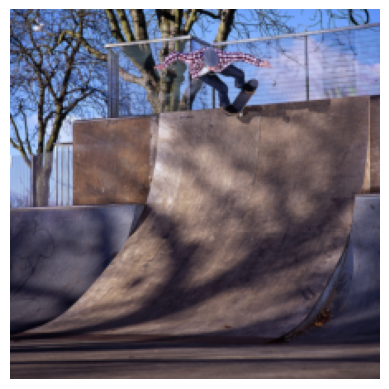

['⛸' '🛼' '🇦🇺' '🐴' '🤸\u200d♀️']
['ice skate' 'roller skate' 'flag: Australia' 'horse face'
 'woman cartwheeling']
[0.99288509 0.99130743 0.989581   0.98933956 0.98852548]


In [366]:
pd_emoji = pd.read_csv('EmojiDataset/emoji_with_embeddings2.csv')
# Get emoji embeddings
emoji_embeddings = pd_emoji.iloc[:, 2:].values

# Fetch a batch of images and captions
images, texts, captions = next(iter(train_loader))
id = 0

# Get image embedding
image_features = model.image_encoder(images[id].unsqueeze(0).to(device))
image_embeddings = model.image_projection(image_features)
image_embeddings = F.normalize(image_embeddings, dim=-1).cpu().detach().numpy()

# Calculate similarity between image and emoji embeddings
similarity = np.dot(image_embeddings, emoji_embeddings.T)

# Show image
plt.imshow(images[id].permute(1, 2, 0)/2+0.5)
plt.axis('off')
plt.show()

# Get top 5 most similar emojis
top5_idx = np.argsort(similarity[0])[::-1][:5]
top5_emojis = pd_emoji.iloc[top5_idx, 0].values
top5_emoji_captions = pd_emoji.iloc[top5_idx, 1].values
print(top5_emojis)
print(top5_emoji_captions)
print(similarity[0][top5_idx])


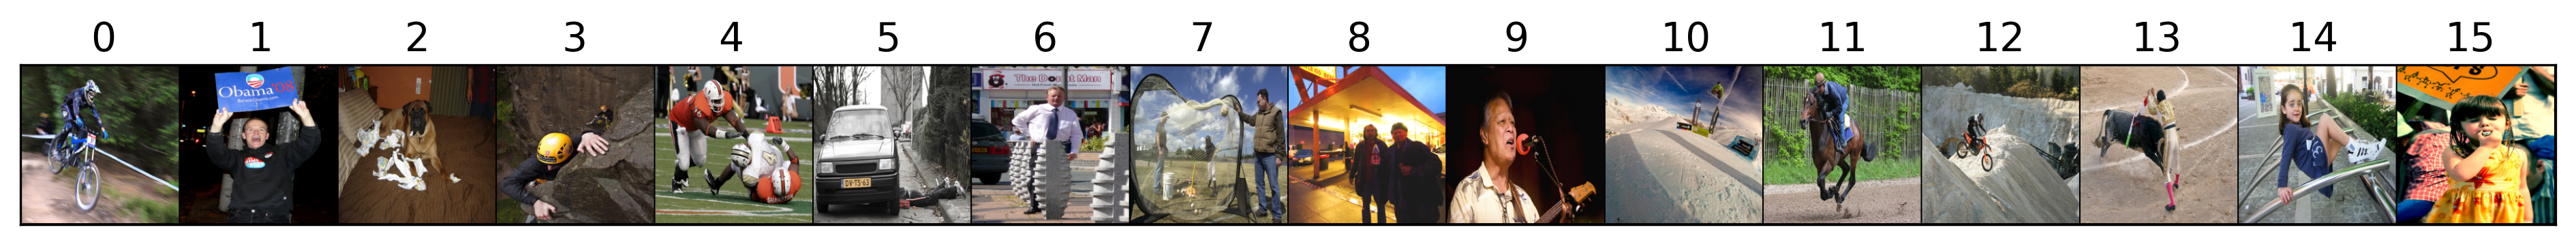

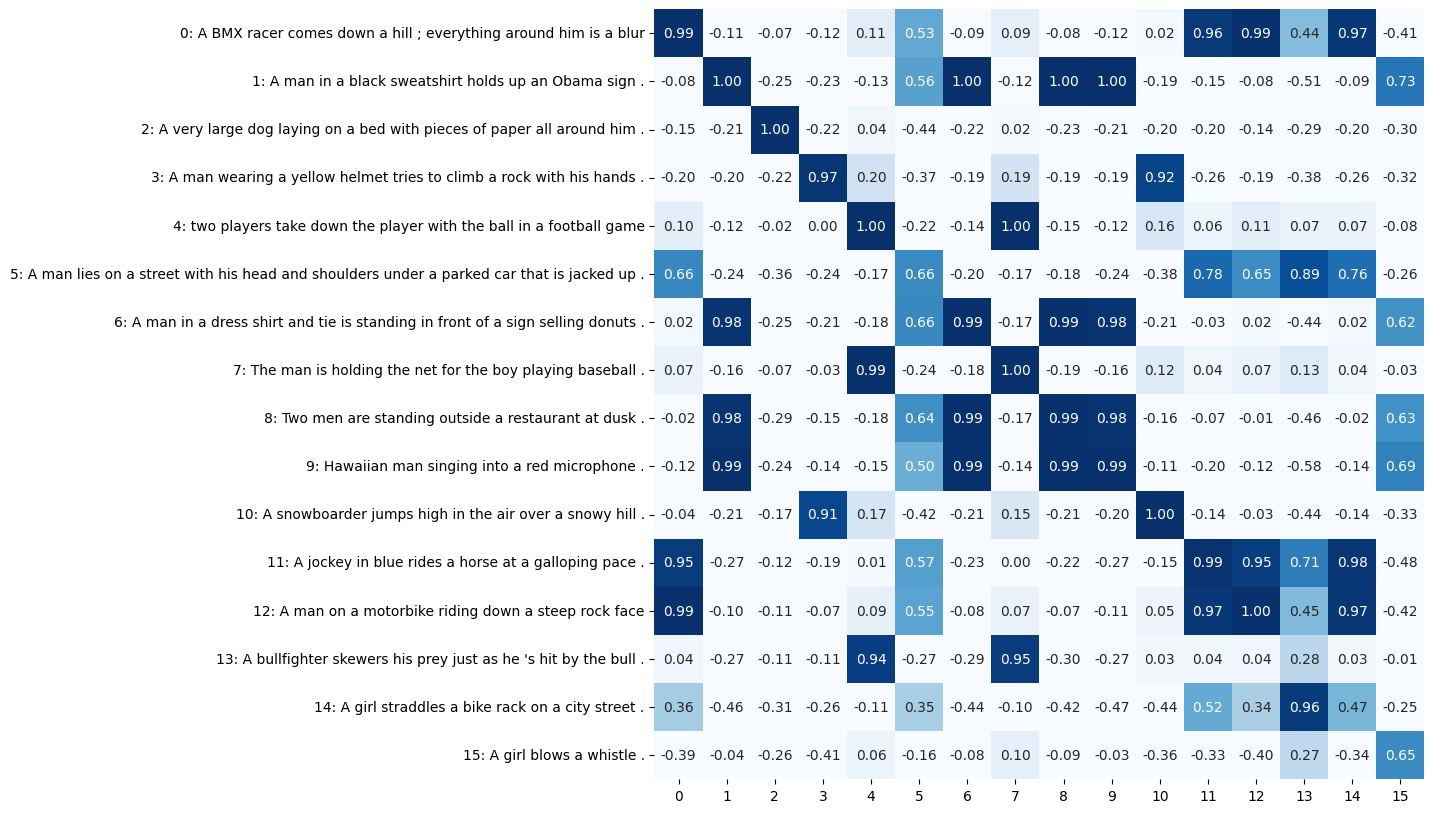

In [370]:
# Fetch a batch of images and captions
images, texts, captions = next(iter(train_loader))

# show images
row_images = images / 2 + 0.5
fig, ax = plt.subplots(figsize=(16, 16), dpi=300)
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(row_images.detach()[:row_images.size(0)], nrow=16).permute(1, 2, 0))
for i in range(row_images.size(0)):
    ax.text(i%16*224+100, i//16*224-20, str(i), fontsize=14, color='black')
plt.show()

# show captions and similarity matrix
plt.figure(figsize=(10,10))
image_embeddings, text_embeddings = model((images.to(device), texts.to(device)))
similarity = np.dot(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy().T)
sns.heatmap(similarity, vmin=0, vmax=1, cmap='Blues', annot=True, square=True, fmt='.2f', cbar=False)
plt.yticks(ticks=np.arange(len(captions))+0.5, labels=[f'{i}: {caption}' for i, caption in enumerate(captions)], rotation=0)
plt.show()

## 📝 Refferences
- [CLIP Paper](https://arxiv.org/abs/2103.00020)
- [CLIP wandb Implementation](https://github.com/soumik12345/clip-lightning)
- [Flickr-8k Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k)
- [Emoji Dataset](https://huggingface.co/datasets/valhalla/emoji-dataset)

## ☑️ To-Do
- Train the model on a larger dataset Flickr-30k
- Train the model on a larger dataset MS-COCO
- Data Augmentation
- Emoji Feature Space